<a href="https://colab.research.google.com/github/MoltenMuffins/IndoorAudioClassifier/blob/master/AudioAsImage_ShallowNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



VGG model trained on self created database of sounds from freesound

Classes: Speech, Music, Water, Door Sounds, Car horn, Glass Breaking

## 0. Boilerplate Code

In [1]:
#test for gpu
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
#imports here
import os
import librosa
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

import tensorflow as tf

tf.VERSION

'1.12.0'

## 1. Download Dataset

We use a small labeled dataset generated via the freesound api and passed through an audio tokeniser to shorten exceedingly long sound files.

It has the following file structure: `Dataset/Train/{CLASS_LABEL}/{FILENAME}.jpg`

In [0]:
#Download Dataset from dropbox
!wget -qq https://www.dropbox.com/s/rv7xzjyvae0nabt/Data.zip

In [4]:
#Unzip and delete zip file
!unzip -qq Data.zip
!rm Data.zip
!ls

Data  __MACOSX	sample_data


## 2. Prepare Dataset for Model

We use glob to get lists of the files in the directories and then convert them into dataframes and add in class numbers.

We also then split them up so we have 10% for a testing set and the rest for training.

Finally we randomly shuffle them up

In [0]:
path = "./Data/"
train_data_dir = "./Data/Train/"

In [6]:
import pandas as pd
import glob

filenames_n0 = glob.glob('./Data/Train/car horn/*.png')
filenames_n1 = glob.glob('./Data/Train/door/*.png')
filenames_n2 = glob.glob('./Data/Train/glass break/*.png')
filenames_n3 = glob.glob('./Data/Train/music/*.png')
filenames_n4 = glob.glob('./Data/Train/speech/*.png')
filenames_n5 = glob.glob('./Data/Train/water/*.png')


names = ['car horn', 'door', 'glass break', 'music', 'speech', 'water']

len(filenames_n0)

52

In [0]:
# Make a dataframe based on the filenames
df = pd.DataFrame(filenames_n0, columns = ["filename"])
df2 = pd.DataFrame(filenames_n1, columns = ["filename"])
df3 = pd.DataFrame(filenames_n2, columns = ["filename"])
df4 = pd.DataFrame(filenames_n3, columns = ["filename"])
df5 = pd.DataFrame(filenames_n4, columns = ["filename"])
df6 = pd.DataFrame(filenames_n5, columns = ["filename"])


# Add Class columns 
df['class'] = pd.Series([0 for x in range(len(df.index))], index=df.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)
df3['class'] = pd.Series([2 for x in range(len(df3.index))], index=df3.index)
df4['class'] = pd.Series([3 for x in range(len(df4.index))], index=df4.index)
df5['class'] = pd.Series([4 for x in range(len(df5.index))], index=df5.index)
df6['class'] = pd.Series([5 for x in range(len(df6.index))], index=df6.index)


# Split into train and validation sets
train_set_percentage = .9

#1
train_df = df[:int(len(df)*train_set_percentage)]
val_df = df[int(len(df)*train_set_percentage):]

#2
train_df2 = df2[:int(len(df2)*train_set_percentage)]
val_df2 = df2[int(len(df2)*train_set_percentage):]

#3
train_df3 = df3[:int(len(df3)*train_set_percentage)]
val_df3 = df3[int(len(df3)*train_set_percentage):]

#4
train_df4 = df4[:int(len(df4)*train_set_percentage)]
val_df4 = df4[int(len(df4)*train_set_percentage):]

#5
train_df5 = df5[:int(len(df5)*train_set_percentage)]
val_df5 = df5[int(len(df5)*train_set_percentage):]

#6
train_df6 = df6[:int(len(df6)*train_set_percentage)]
val_df6 = df6[int(len(df6)*train_set_percentage):]

df_new_train = pd.concat([train_df, train_df2, train_df3, train_df4, train_df5, train_df6])
df_new_val = pd.concat([val_df, val_df2, val_df3, val_df4, val_df5, val_df6])

In [8]:
# shuffle dataframes
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

print('number of train files:', len(df))
print('number of val files:', len(df_val))
df.head(10)

number of train files: 905
number of val files: 104


,filename,class
0,"./Data/Train/door/Door Squeak, Normal, A.png",1
1,./Data/Train/speech/corpspeech_clip2.png,4
2,./Data/Train/water/water-in-container_clip0.png,5
3,./Data/Train/speech/tata_stan_brian01_clip5.png,4
4,./Data/Train/water/water splash 2.png,5
5,./Data/Train/car horn/car_horn_clip0.png,0
6,"./Data/Train/door/Door Squeak, Normal, C.png",1
7,./Data/Train/speech/mean_grinch_christmas_01_c...,4
8,./Data/Train/water/Water Dropping.png,5
9,./Data/Train/door/door_slams_r_clip0.png,1


In [9]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

#number of classes
num_classes = 6

df.shape

(905, 2)

In [10]:
train_filenames_list[:5]

['./Data/Train/door/Door Squeak, Normal, A.png',
 './Data/Train/speech/corpspeech_clip2.png',
 './Data/Train/water/water-in-container_clip0.png',
 './Data/Train/speech/tata_stan_brian01_clip5.png',
 './Data/Train/water/water splash 2.png']

## 3. Shallow NN

### 3.1 Create Data Pipeline for Our NN

In [0]:
#As our image is greyscale (single channel) we need to do something to it to make it 3 channeled

# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.

def _parse_function(filename, label):
  image_string = tf.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  label = tf.one_hot(label, num_classes)
  return image_decoded, label

In [0]:
# Create vector of filenames from list
filenames = tf.constant(train_filenames_list)

# Create vector of labels
labels = tf.constant(train_labels_list)

# Same as above but for validation set
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

### 3.2 Asemble Data Pipeline using tf.data for VGG16

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(32)

valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(32)

In [0]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(64, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [0]:
opt = tf.train.AdamOptimizer(learning_rate = 0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

### 3.3 Run Neural Network

In [0]:
#60 20 20 rule
train_steps = 60
val_steps = 20
epochs = 30

In [27]:
#sanity check
print(train_dataset)
print(valid_dataset)

<BatchDataset shapes: ((?, ?, ?, 3), (?, 6)), types: (tf.uint8, tf.float32)>
<BatchDataset shapes: ((?, ?, ?, 3), (?, 6)), types: (tf.uint8, tf.float32)>


In [28]:
# # # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Epoch 1/30
60/60 [==============================] - 4s 71ms/step - loss: 12.8634 - acc: 0.1505 - val_loss: 11.7195 - val_acc: 0.1844
Epoch 2/30
60/60 [==============================] - 1s 23ms/step - loss: 12.6715 - acc: 0.1573 - val_loss: 11.5299 - val_acc: 0.1625
Epoch 3/30
60/60 [==============================] - 1s 23ms/step - loss: 12.5516 - acc: 0.1609 - val_loss: 10.8561 - val_acc: 0.1812
Epoch 4/30
60/60 [==============================] - 1s 23ms/step - loss: 12.0601 - acc: 0.1807 - val_loss: 10.2815 - val_acc: 0.2078
Epoch 5/30
60/60 [==============================] - 1s 22ms/step - loss: 11.5582 - acc: 0.1943 - val_loss: 9.2368 - val_acc: 0.2703
Epoch 6/30
60/60 [==============================] - 1s 23ms/step - loss: 11.1319 - acc: 0.2078 - val_loss: 8.8627 - val_acc: 0.2797
Epoch 7/30
60/60 [==============================] - 1s 22ms/step - loss: 10.7778 - acc: 0.2094 - val_loss: 8.7087 - val_acc: 0.2719
Epoch 8/30
60/60 [==============================] - 1s 22ms/step - loss:

In [30]:
# # # Let's train it more just to see what happens (will probably overfit given lack of data)
epochs = 1000

history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

60/60 [==============================] - 1s 23ms/step - loss: 0.6236 - acc: 0.7396 - val_loss: 2.6599 - val_acc: 0.5781
Epoch 994/1000
60/60 [==============================] - 1s 23ms/step - loss: 0.6159 - acc: 0.7438 - val_loss: 2.6153 - val_acc: 0.5766
Epoch 995/1000
60/60 [==============================] - 1s 23ms/step - loss: 0.6230 - acc: 0.7375 - val_loss: 2.6351 - val_acc: 0.5797
Epoch 996/1000
60/60 [==============================] - 1s 23ms/step - loss: 0.6549 - acc: 0.7281 - val_loss: 2.6973 - val_acc: 0.5625
Epoch 997/1000
60/60 [==============================] - 1s 23ms/step - loss: 0.6366 - acc: 0.7313 - val_loss: 2.7112 - val_acc: 0.5750
Epoch 998/1000
60/60 [==============================] - 1s 23ms/step - loss: 0.6301 - acc: 0.7385 - val_loss: 2.6790 - val_acc: 0.5797
Epoch 999/1000
60/60 [==============================] - 1s 23ms/step - loss: 0.6230 - acc: 0.7339 - val_loss: 2.6605 - val_acc: 0.5781
Epoch 1000/1000
60/60 [==============================] - 1s 23ms/step 

## 4. Model Adhoc Test

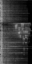

In [49]:
image_path = './Data/Test/'

from IPython.display import Image

#Filenames:'horn.png', 'door.png', 'glass.png', 'music.png', 'speech.png', 'water.png'
image_check = 'glass.png'
#These files are not present in the train set

Image(image_path+image_check)

In [50]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import numpy as np

img_path = os.path.join(image_path, image_check)
print(img_path)
img = image.load_img(img_path, target_size=(64,32))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

./Data/Test/glass.png
Input image shape: (1, 64, 32, 3)


In [51]:
preds = model.predict(x)
print(preds)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.8362808e-19 1.0000000e+00
  0.0000000e+00]]


In [52]:
import operator
def decode(preds):
  names = ['car horn', 'door', 'glass break', 'music', 'speech', 'water']
  probs = preds[0].tolist()
  dictionary = dict(zip(names, probs))  
  return sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)
  
decode(preds)

[('speech', 1.0),
 ('music', 2.836280828291863e-19),
 ('car horn', 0.0),
 ('door', 0.0),
 ('glass break', 0.0),
 ('water', 0.0)]